In [1]:
import numpy as np
import pandas
import mpl_toolkits.basemap as bm
import matplotlib.pyplot as plt

In [2]:
import sklearn.metrics
import sklearn.feature_extraction

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
%aimport py_cluster
import cy_cluster # aimport won't work on .so

In [5]:
%matplotlib inline

### Loading data

In [6]:
table = np.copy(pandas.read_table('data.tsv', na_filter=False, header=None).values, order='C')

In [7]:
cv = sklearn.feature_extraction.text.CountVectorizer()

In [8]:
data = np.copy(table[:, -3:].astype(np.float), order='C')
labels = cv.fit_transform(table[:, 1]) * np.arange(len(set(table[:, 1])))

In [9]:
AF = np.where(table[:, 0] == 'AF')[0]
AS = np.where(table[:, 0] == 'AS')[0]
EU = np.where(table[:, 0] == 'EU')[0]
NA = np.where(table[:, 0] == 'NA')[0]
OC = np.where(table[:, 0] == 'OC')[0]
SA = np.where(table[:, 0] == 'SA')[0]

In [109]:
def plot(data, name=None, clusters=None, s=20, save=False, fname=None):
    plt.rcParams['figure.figsize'] = 15, 15
    minlat = np.min(data[:, 1])
    maxlat = np.max(data[:, 1])
    if name == 'EU' or name == 'OC' or name == 'WORLD':
        minlat = -90
        maxlat = 90
    map = bm.Basemap(projection='mill', llcrnrlon=np.min(data[:, 2]), llcrnrlat=minlat,
                     urcrnrlon=np.max(data[:, 2]), urcrnrlat=maxlat)

    map.drawmapboundary(fill_color='aqua')
    map.fillcontinents(color='#FFFCDD',lake_color='aqua', zorder=0)
    map.drawcoastlines(linewidth=0.3)
    map.drawcountries(linewidth=0.7)

    x, y = map(data[:, 2], data[:, 1])
    map.scatter(x, y, s=s, edgecolors='none', c=np.zeros(data.shape[0]) if clusters is None else clusters)
    plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']
    if save:
        if fname == None:
            print('No file name. File won\'t be saved')
        else:
            plt.savefig(fname, bbox_inches='tight')
    plt.show()


##Performance comparison

Для того, чтобы методы работали 50 итераций, в каждом методе нужно поменять флаг nonIter на false

In [11]:
import time

In [12]:
score_k_means_py = np.empty(NA.size // 100)
score_k_medoids_py = np.empty(NA.size // 100)
score_k_means_cy = np.empty(NA.size // 100)
score_k_medoids_cpp = np.empty(NA.size // 100)

In [13]:
clusters_number = len(set(labels[NA]))
for i in range(100, NA.size, 100):
    indxs = np.random.randint(0, NA.size, i)
    clusters = np.empty(i, dtype=np.int)
    
    _time = time.clock()
    py_cluster.k_means(data[NA[indxs]], i, clusters_number, clusters)
    score_k_means_py[i // 100 - 1] = time.clock() - _time
    
    _time = time.clock()
    py_cluster.k_medoids(data[NA[indxs]], i, clusters_number, clusters)
    score_k_medoids_py[i // 100 - 1] = time.clock() - _time
    
    _time = time.clock()
    cy_cluster.k_means(data[NA[indxs]], i, clusters_number, clusters)
    score_k_means_cy[i // 100 - 1] = time.clock() - _time
    
    _time = time.clock()
    cy_cluster.k_medoids(data[NA[indxs]], i, clusters_number, clusters)
    score_k_medoids_cpp[i // 100 - 1] = time.clock() - _time

In [15]:
# BU data
# np.savetxt('bu/score_k_means_cy.csv', score_k_means_cy, delimiter=',')
# np.savetxt('bu/score_k_means_py.csv', score_k_means_py, delimiter=',')
# np.savetxt('bu/score_k_medoids_cpp.csv', score_k_medoids_cpp, delimiter=',')
# np.savetxt('bu/score_k_medoids_py.csv', score_k_medoids_py, delimiter=',')

In [11]:
score_k_means_cy = pandas.read_csv('bu/score_k_means_cy.csv', header=None).values.ravel()
score_k_means_py = pandas.read_csv('bu/score_k_means_py.csv', header=None).values.ravel()
score_k_medoids_cpp = pandas.read_csv('bu/score_k_medoids_cpp.csv', header=None).values.ravel()
score_k_medoids_py = pandas.read_csv('bu/score_k_medoids_py.csv', header=None).values.ravel()

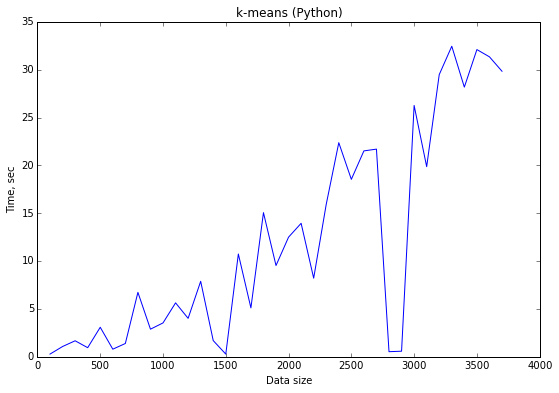

In [12]:
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(np.arange(100, NA.size, 100), score_k_means_py)
plt.title('k-means (Python)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')

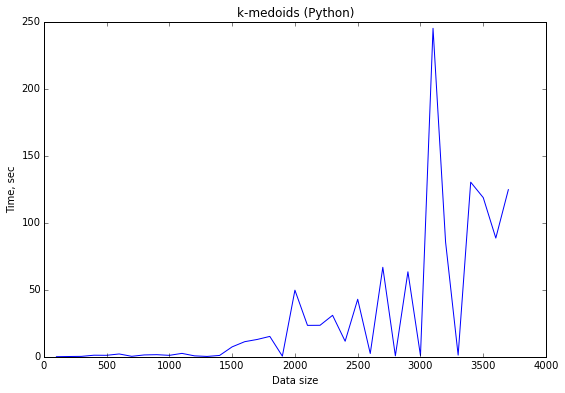

In [13]:
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_py)
plt.title('k-medoids (Python)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')

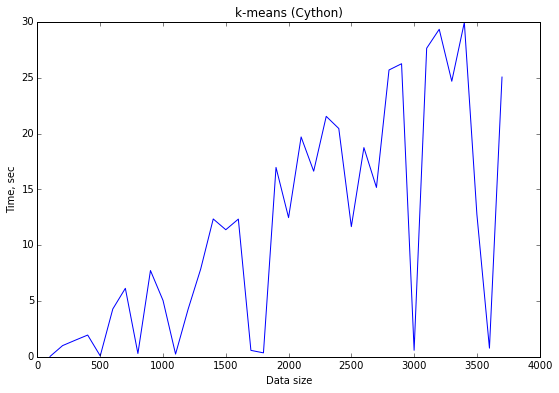

In [14]:
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(np.arange(100, NA.size, 100), score_k_means_cy)
plt.title('k-means (Cython)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')

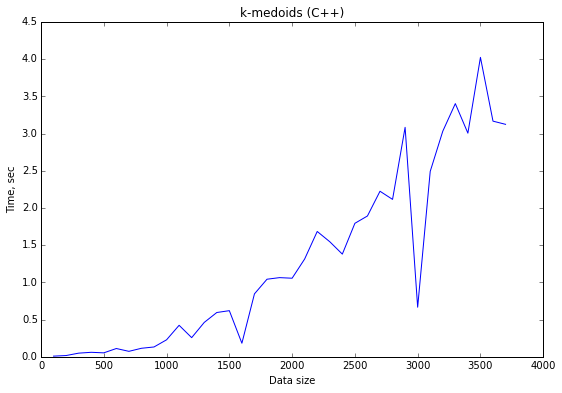

In [15]:
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_cpp)
plt.title('k-medoids (C++)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')

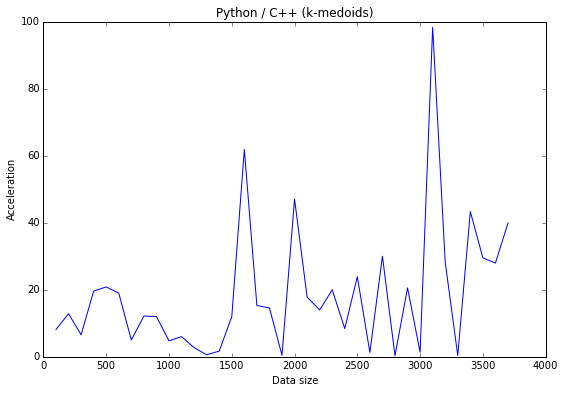

In [17]:
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_py / score_k_medoids_cpp)
plt.title('Python / C++ (k-medoids)')
plt.xlabel('Data size')
plt.ylabel('Acceleration')

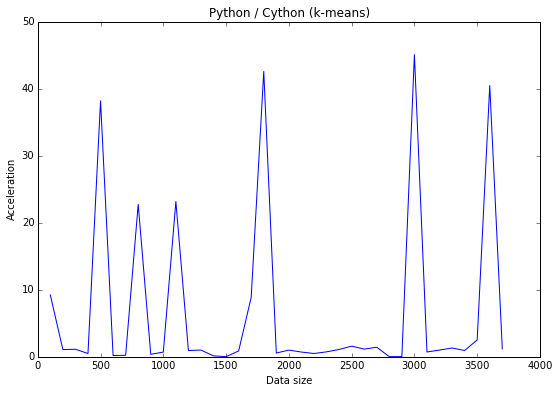

In [30]:
plt.rcParams['figure.figsize'] = 9, 6
plt.plot(np.arange(100, NA.size, 100), score_k_means_py / score_k_means_cy)
plt.title('Python / Cython (k-means)')
plt.xlabel('Data size')
plt.ylabel('Acceleration')

In [18]:
from sklearn import linear_model

In [19]:
ols = linear_model.LinearRegression().fit(np.arange(100, NA.size, 100)[:, np.newaxis], score_k_medoids_py / score_k_medoids_cpp)

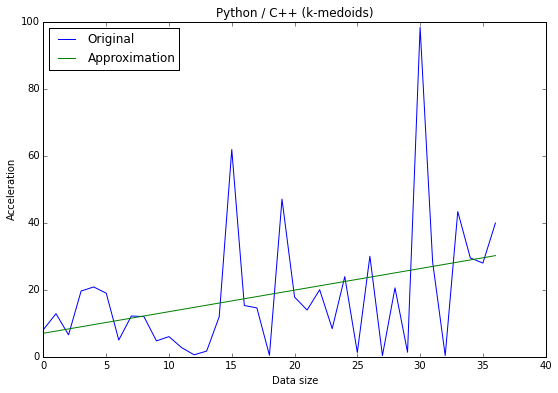

In [22]:
plt.plot(score_k_medoids_py / score_k_medoids_cpp, label='Original')
plt.plot(ols.predict(np.arange(100, NA.size, 100)[:, np.newaxis]), label='Approximation')
plt.title('Python / C++ (k-medoids)')
plt.xlabel('Data size')
plt.ylabel('Acceleration')
plt.legend(loc='best')

In [31]:
ols = linear_model.LinearRegression().fit(np.arange(100, NA.size, 100)[:, np.newaxis], score_k_means_py / score_k_means_cy)

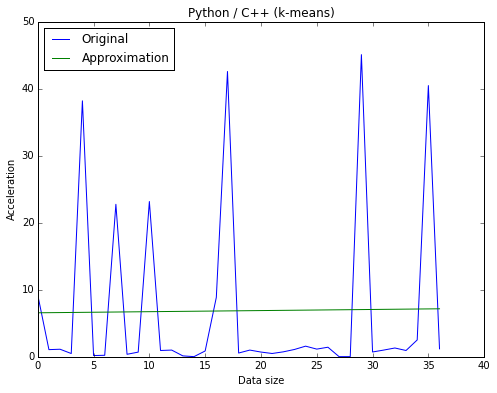

In [114]:
plt.plot(score_k_means_py / score_k_means_cy, label='Original')
plt.plot(ols.predict(np.arange(100, NA.size, 100)[:, np.newaxis]), label='Approximation')
plt.title('Python / C++ (k-means)')
plt.xlabel('Data size')
plt.ylabel('Acceleration')
plt.legend(loc='best')

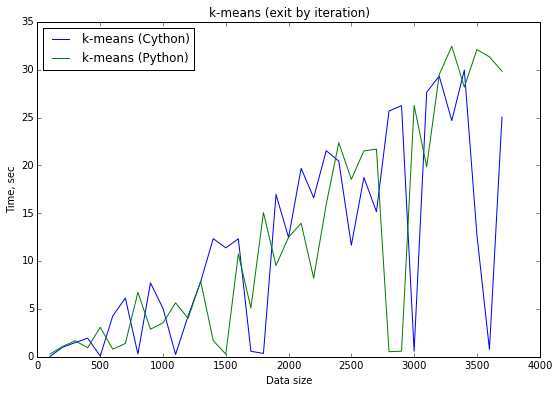

In [23]:
plt.rcParams['figure.figsize'] = 9, 6
plt.title('k-means (exit by iteration)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')
plt.plot(np.arange(100, NA.size, 100), score_k_means_cy, label='k-means (Cython)')
plt.plot(np.arange(100, NA.size, 100), score_k_means_py, label='k-means (Python)')
plt.legend(loc='best')

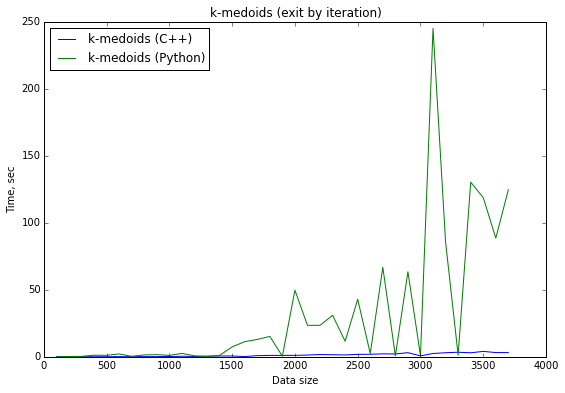

In [24]:
plt.rcParams['figure.figsize'] = 9, 6
plt.title('k-medoids (exit by iteration)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_cpp, label='k-medoids (C++)')
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_py, label='k-medoids (Python)')
plt.legend(loc='best')

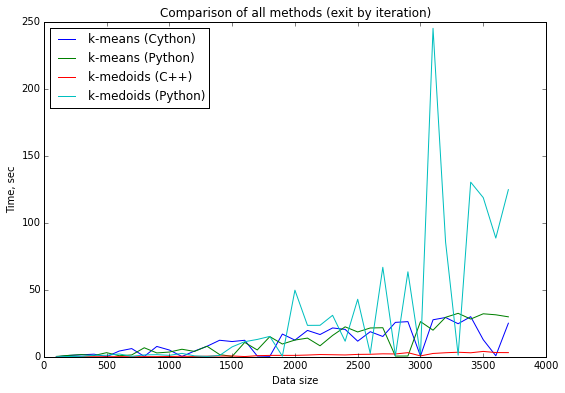

In [25]:
plt.rcParams['figure.figsize'] = 9, 6
plt.title('Comparison of all methods (exit by iteration)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')
plt.plot(np.arange(100, NA.size, 100), score_k_means_cy, label='k-means (Cython)')
plt.plot(np.arange(100, NA.size, 100), score_k_means_py, label='k-means (Python)')
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_cpp, label='k-medoids (C++)')
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_py, label='k-medoids (Python)')
plt.legend(loc='best')

####Здесь мы ищем самую быструю реализацию, но уже с выходом по схождению

In [26]:
score_k_means_cy_non = pandas.read_csv('score_k_means_cy_noniter.csv', header=None).values.ravel()
score_k_means_py_non = pandas.read_csv('score_k_means_py_noniter.csv', header=None).values.ravel()
score_k_medoids_cpp_non = pandas.read_csv('score_k_medoids_cpp_noniter.csv', header=None).values.ravel()
score_k_medoids_py_non = pandas.read_csv('score_k_medoids_py_noniter.csv', header=None).values.ravel()

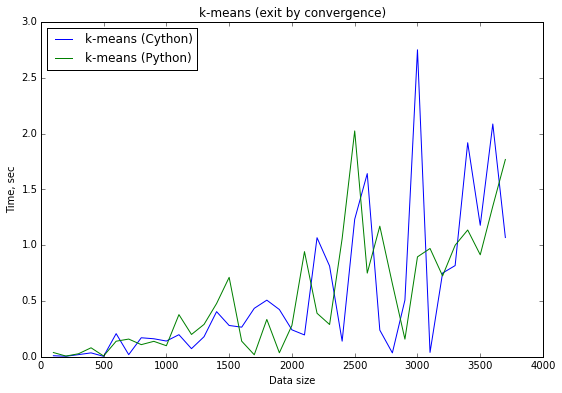

In [28]:
plt.rcParams['figure.figsize'] = 9, 6
plt.title('k-means (exit by convergence)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')
plt.plot(np.arange(100, NA.size, 100), score_k_means_cy_non, label='k-means (Cython)')
plt.plot(np.arange(100, NA.size, 100), score_k_means_py_non, label='k-means (Python)')
plt.legend(loc='best')

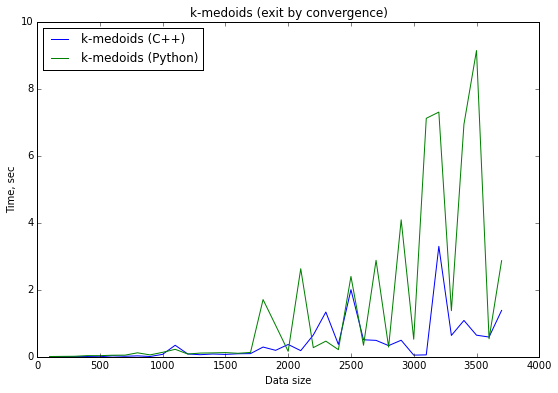

In [29]:
plt.rcParams['figure.figsize'] = 9, 6
plt.title('k-medoids (exit by convergence)')
plt.xlabel('Data size')
plt.ylabel('Time, sec')
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_cpp_non, label='k-medoids (C++)')
plt.plot(np.arange(100, NA.size, 100), score_k_medoids_py_non, label='k-medoids (Python)')
plt.legend(loc='best')

<b>Быстрые алгоритмы: k-Means на Cython, k-Medoids на C++</b>

#Clasterization

### World

In [110]:
clust = np.empty(data.shape[0], dtype=np.int)
%time cy_cluster.k_means(data, data.shape[0], len(set(labels)), clust)
sklearn.metrics.adjusted_rand_score(labels, clust)

CPU times: user 2.23 s, sys: 464 ms, total: 2.7 s
Wall time: 2.91 s


0.4115542915718655

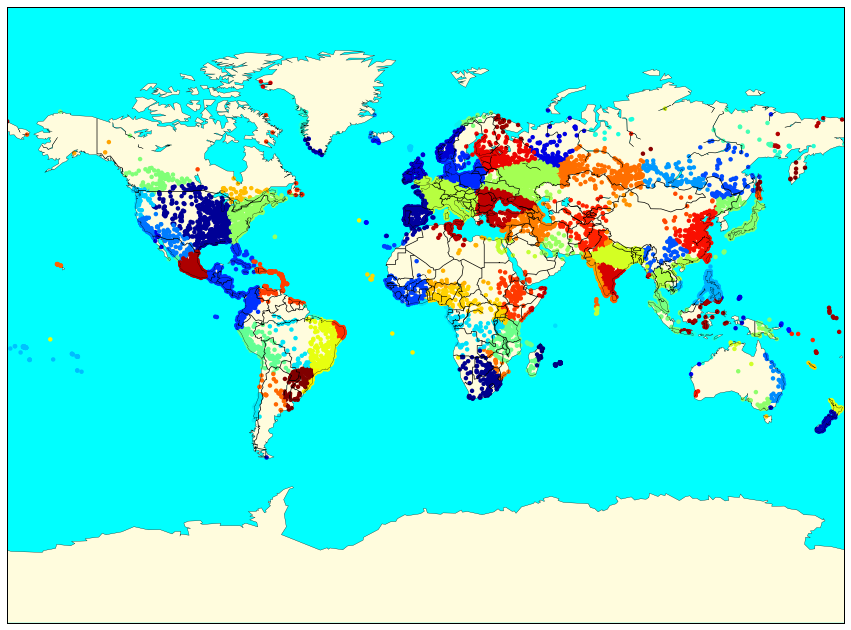

In [111]:
plot(data, 'WORLD', clust, s=20, save=True, fname='W_k_means.pdf')

In [112]:
%time cy_cluster.k_medoids(data, data.shape[0], len(set(labels)), clust)
sklearn.metrics.adjusted_rand_score(labels, clust)

CPU times: user 11 s, sys: 139 ms, total: 11.2 s
Wall time: 11.5 s


0.49288542358015014

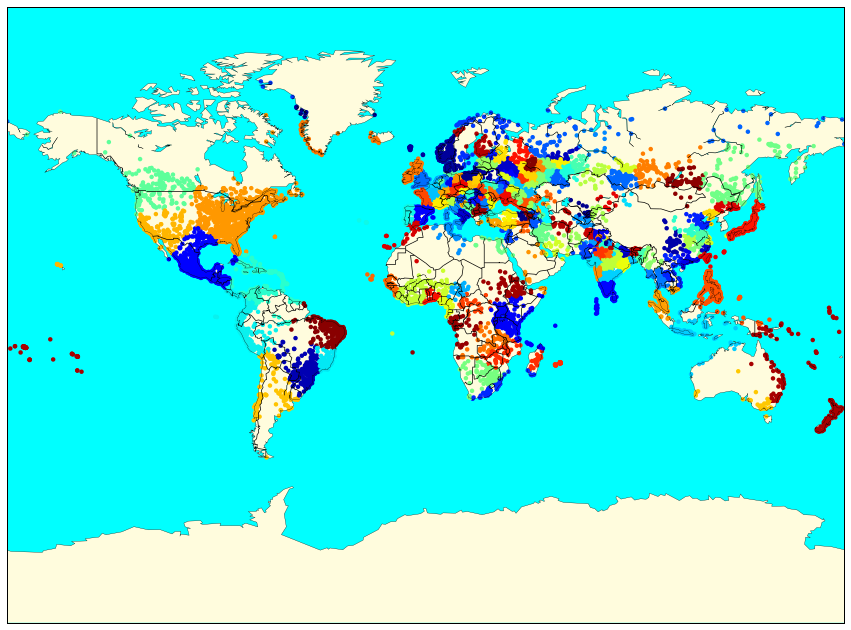

In [113]:
plot(data, 'WORLD', clust, s=20, save=True, fname='W_k_medoids.pdf')

### Africa

In [52]:
clust = np.empty(AF.size, dtype=np.int)
%time cy_cluster.k_means(data[AF], AF.size, len(set(labels[AF])), clust)
sklearn.metrics.adjusted_rand_score(labels[AF], clust)

CPU times: user 208 ms, sys: 10.9 ms, total: 219 ms
Wall time: 215 ms


0.40554358912363103

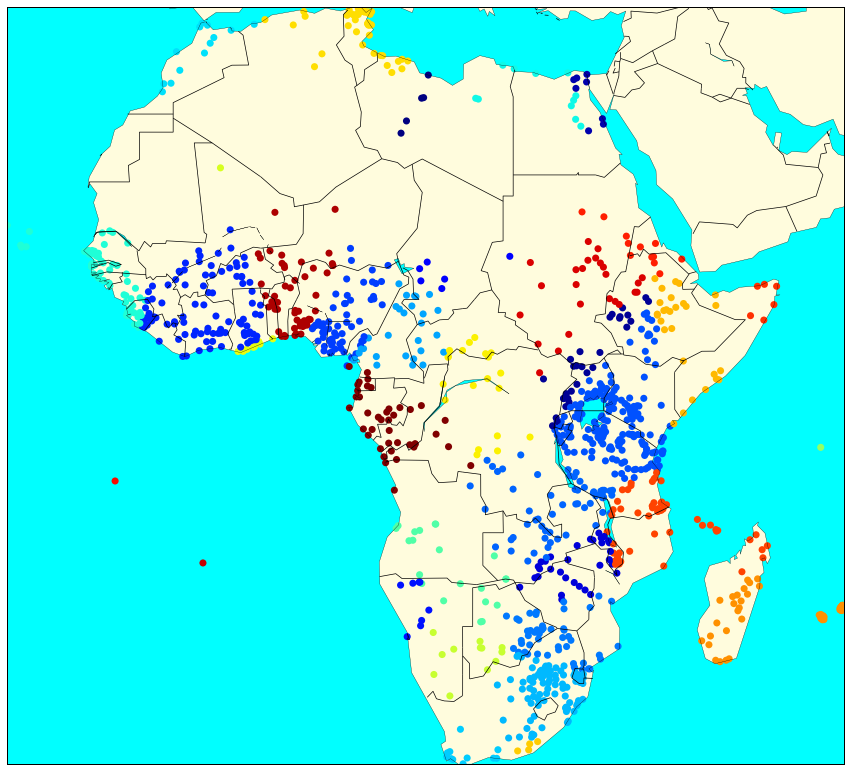

In [53]:
plot(data[AF], 'AF', clust, s=50, save=True, fname='AF_k_means.pdf')

In [54]:
%time cy_cluster.k_medoids(data[AF], AF.size, len(set(labels[AF])), clust)
sklearn.metrics.adjusted_rand_score(labels[AF], clust)

CPU times: user 67.3 ms, sys: 1.07 ms, total: 68.4 ms
Wall time: 71.1 ms


0.3947210620513886

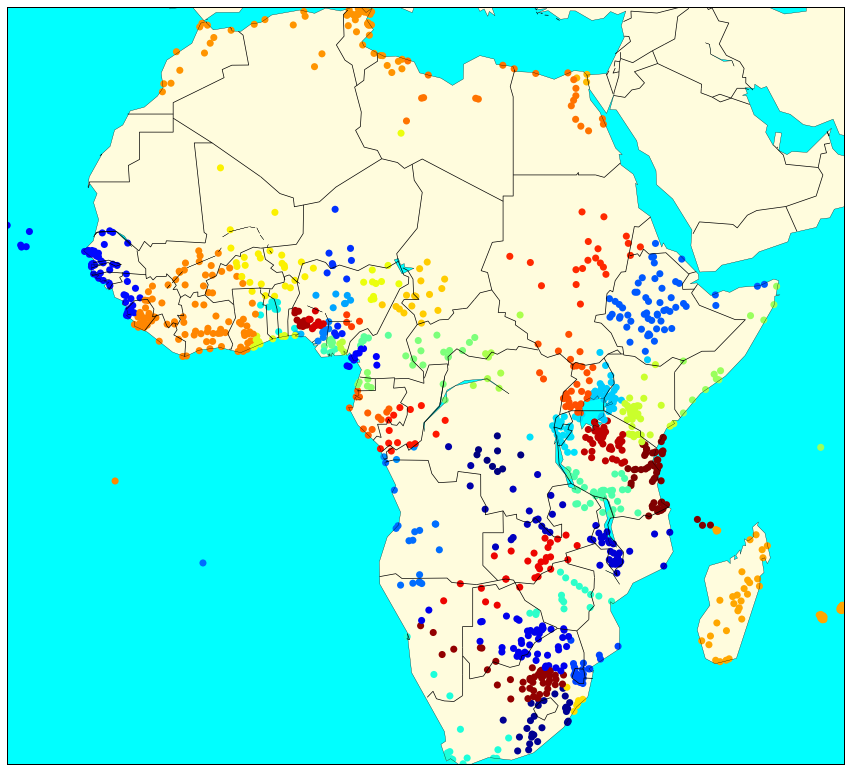

In [55]:
plot(data[AF], 'AF', clust, s=50, save=True, fname='AF_k_medoids.pdf')

### Asia

In [78]:
clust = np.empty(AS.size, dtype=np.int)
%time cy_cluster.k_means(data[AS], AS.size, len(set(labels[AS])), clust)
sklearn.metrics.adjusted_rand_score(labels[AS], clust)

CPU times: user 1.32 s, sys: 30 ms, total: 1.35 s
Wall time: 1.38 s


0.5484319326010236

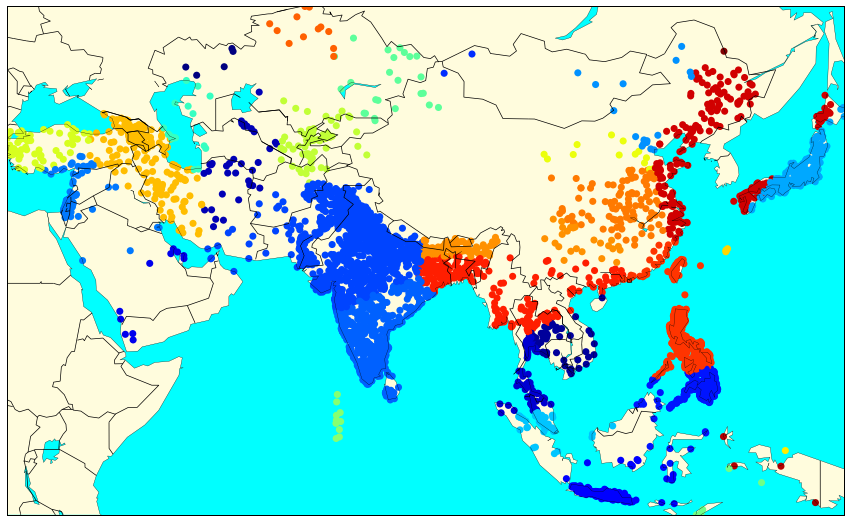

In [79]:
plot(data[AS], 'AS', clust, s=50, save=True, fname='AS_k_means.pdf')

In [70]:
%time cy_cluster.k_medoids(data[AS], AS.size, len(set(labels[AS])), clust)
sklearn.metrics.adjusted_rand_score(labels[AS], clust)

CPU times: user 771 ms, sys: 39.3 ms, total: 811 ms
Wall time: 1.06 s


0.5760478461193669

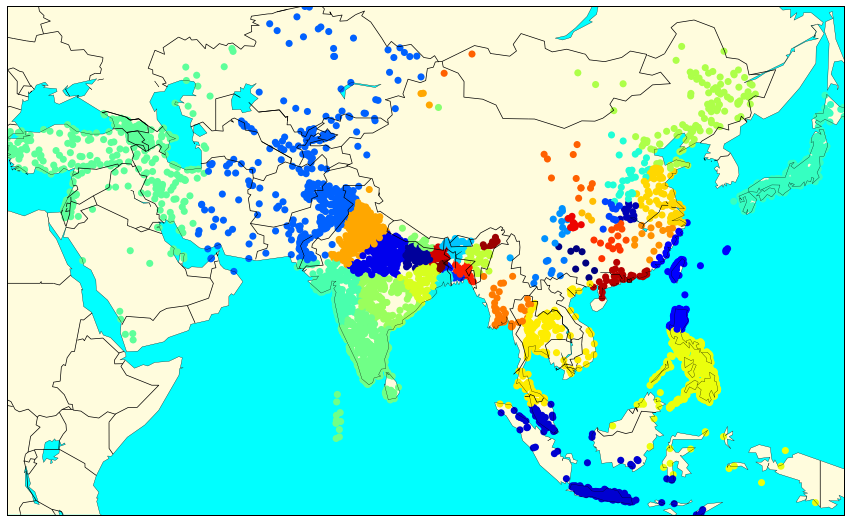

In [71]:
plot(data[AS], 'AS', clust, s=50, save=True, fname='AS_k_medoids.pdf')

### Australia

In [81]:
clust = np.empty(OC.size, dtype=np.int)
%time cy_cluster.k_means(data[OC], OC.size, len(set(labels[OC])), clust)
sklearn.metrics.adjusted_rand_score(labels[OC], clust)

CPU times: user 182 ms, sys: 18.9 ms, total: 200 ms
Wall time: 223 ms


0.5517404556820894

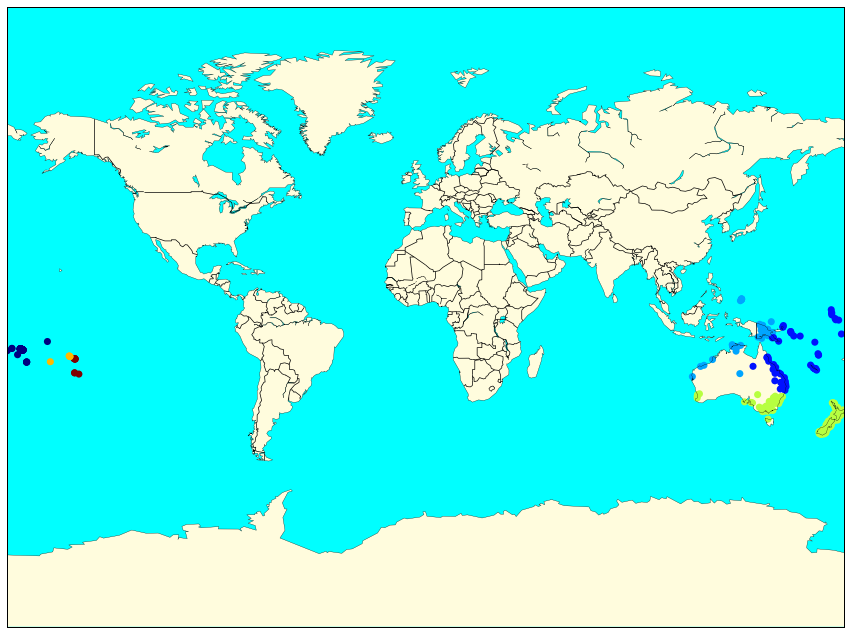

In [82]:
plot(data[OC], 'OC', clust, s=50, save=True, fname='OC_k_means.pdf')

In [86]:
%time cy_cluster.k_medoids(data[OC], OC.size, len(set(labels[OC])), clust)
sklearn.metrics.adjusted_rand_score(labels[OC], clust)

CPU times: user 12.8 ms, sys: 429 µs, total: 13.3 ms
Wall time: 14.3 ms


0.2675713087010923

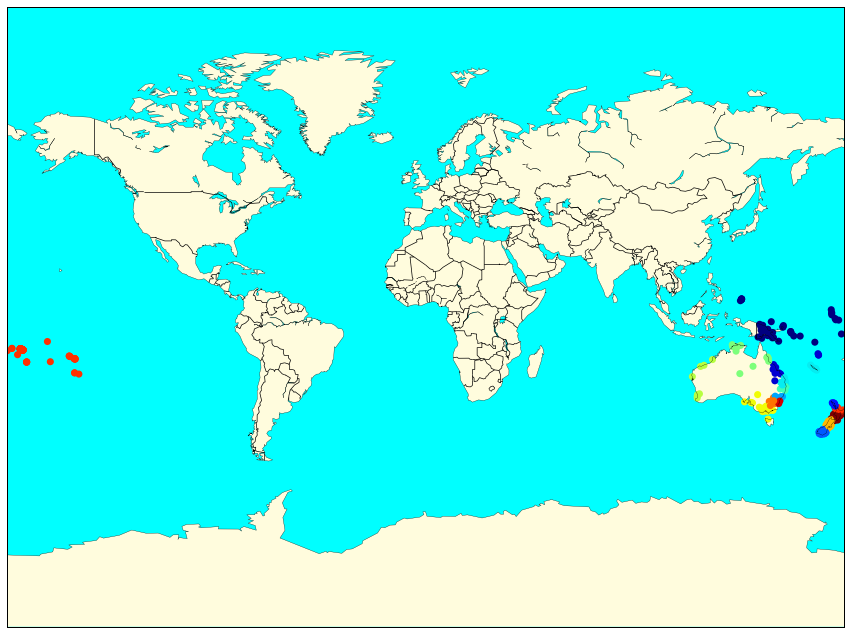

In [89]:
plot(data[OC], 'OC', clust, s=50, save=True, fname='OC_k_medoids.pdf')

### Europe

In [92]:
clust = np.empty(EU.size, dtype=np.int)
%time cy_cluster.k_means(data[EU], EU.size, len(set(labels[EU])), clust)
sklearn.metrics.adjusted_rand_score(labels[EU], clust)

CPU times: user 1.89 s, sys: 60.2 ms, total: 1.95 s
Wall time: 1.98 s


0.26068929371002036

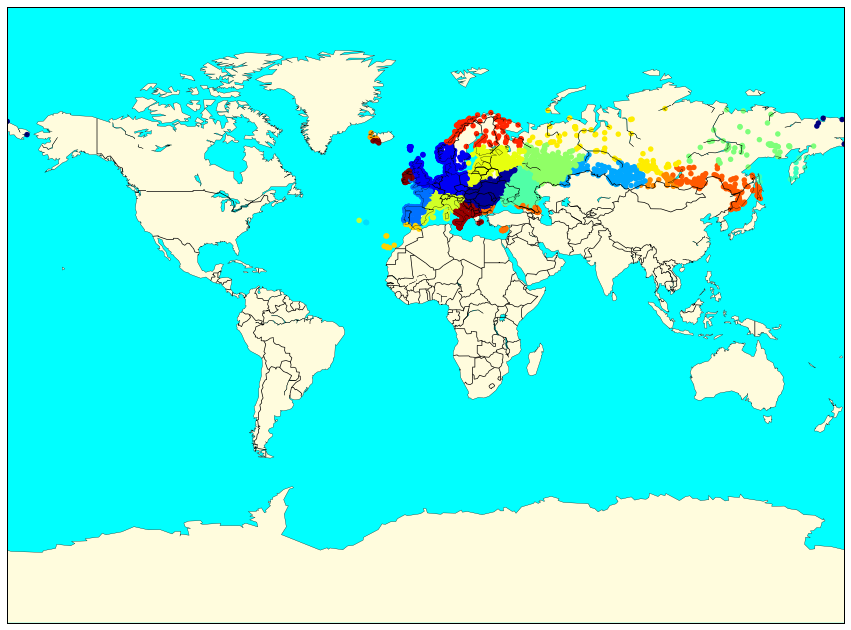

In [95]:
plot(data[EU], 'EU', clust, s=30, save=True, fname='EU_k_means.pdf')

In [96]:
%time cy_cluster.k_medoids(data[EU], EU.size, len(set(labels[EU])), clust)
sklearn.metrics.adjusted_rand_score(labels[EU], clust)

CPU times: user 7.21 s, sys: 108 ms, total: 7.32 s
Wall time: 7.55 s


0.40624891233090793

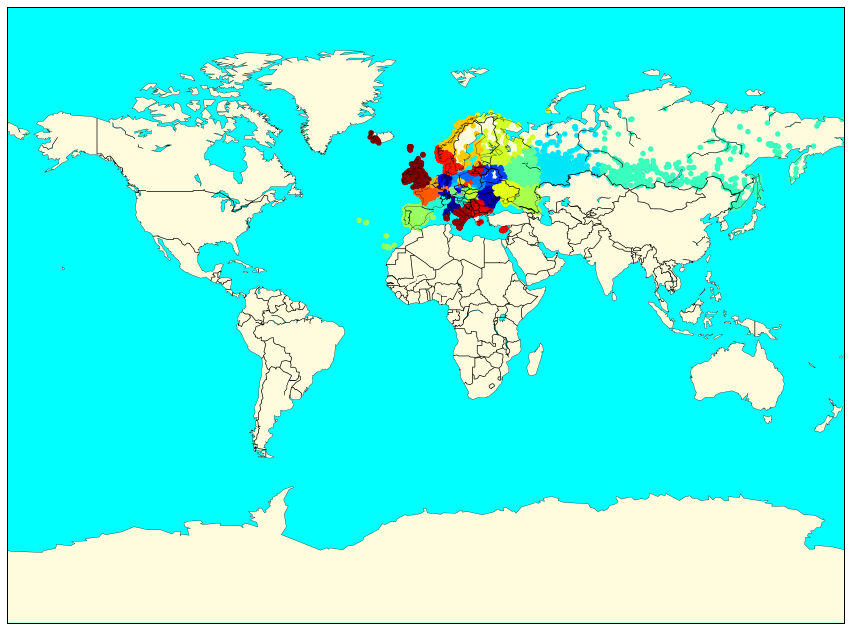

In [98]:
plot(data[EU], 'EU', clust, s=30, save=True, fname='EU_k_medoids.pdf')

### North America

In [99]:
clust = np.empty(NA.size, dtype=np.int)
%time cy_cluster.k_means(data[NA], NA.size, len(set(labels[NA])), clust)
sklearn.metrics.adjusted_rand_score(labels[NA], clust)

CPU times: user 287 ms, sys: 12.2 ms, total: 299 ms
Wall time: 303 ms


0.36519159619045843

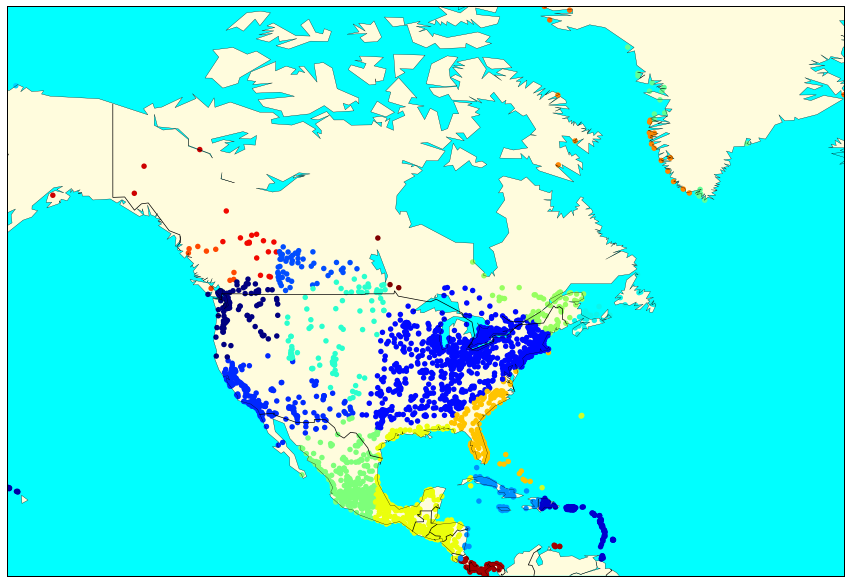

In [100]:
plot(data[NA], 'NA', clust, s=30, save=True, fname='NA_k_means.pdf')

In [101]:
%time cy_cluster.k_medoids(data[NA], NA.size, len(set(labels[NA])), clust)
sklearn.metrics.adjusted_rand_score(labels[NA], clust)

CPU times: user 1.16 s, sys: 14.3 ms, total: 1.18 s
Wall time: 1.2 s


0.09697630815995219

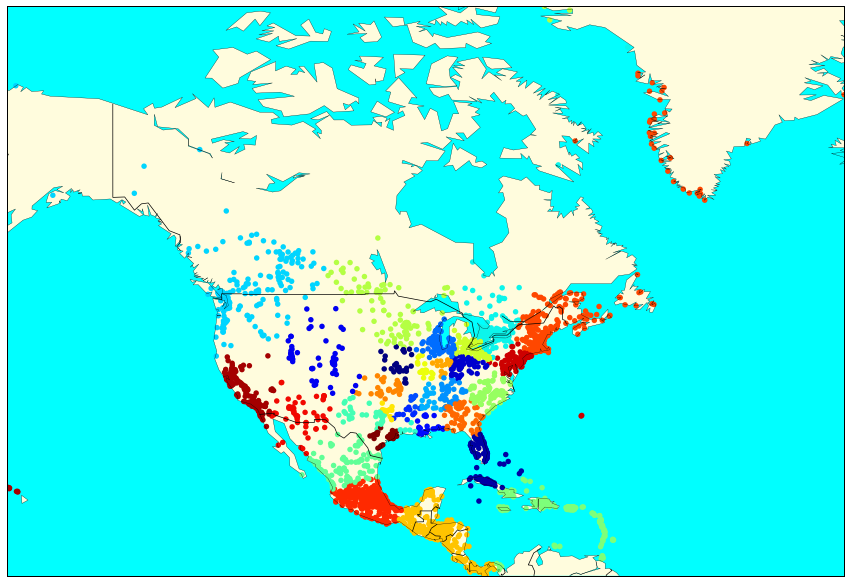

In [102]:
plot(data[NA], 'NA', clust, s=30, save=True, fname='NA_k_medoids.pdf')

### South America

In [103]:
clust = np.empty(SA.size, dtype=np.int)
%time cy_cluster.k_means(data[SA], SA.size, len(set(labels[SA])), clust)
sklearn.metrics.adjusted_rand_score(labels[SA], clust)

CPU times: user 208 ms, sys: 8.86 ms, total: 216 ms
Wall time: 211 ms


0.44026873839558167

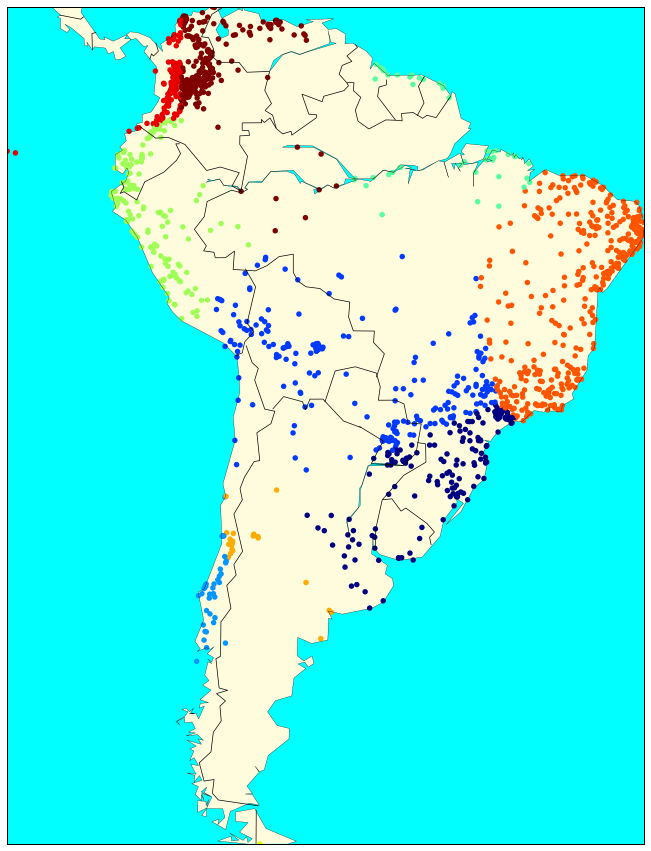

In [104]:
plot(data[SA], 'SA', clust, s=30, save=True, fname='SA_k_means.pdf')

In [107]:
%time cy_cluster.k_medoids(data[SA], SA.size, len(set(labels[SA])), clust)
sklearn.metrics.adjusted_rand_score(labels[SA], clust)

CPU times: user 167 ms, sys: 1.76 ms, total: 169 ms
Wall time: 170 ms


0.35238723891215756

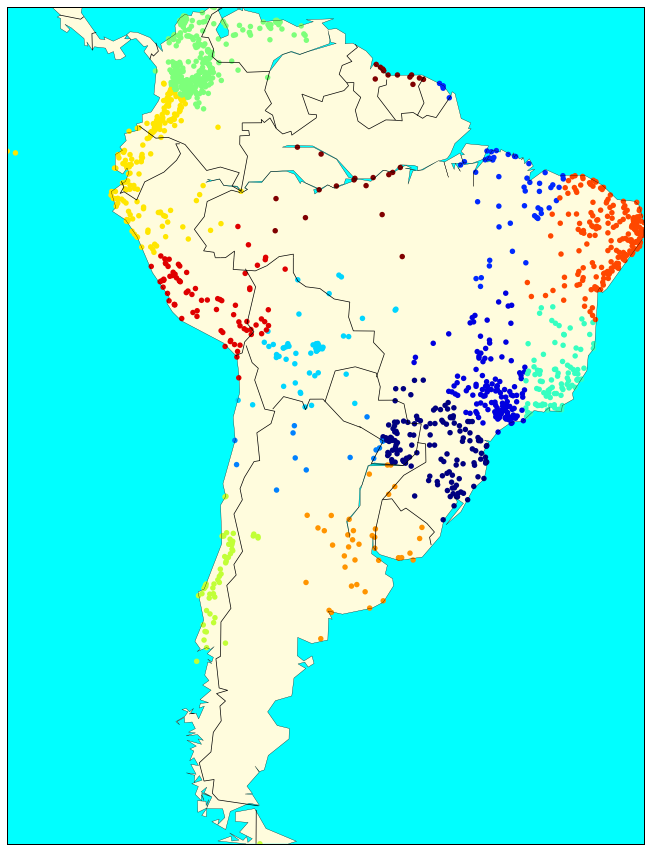

In [108]:
plot(data[SA], 'SA', clust, s=30, save=True, fname='SA_k_medoids.pdf')